# Notebook file for rough work

Scaffolds my work until I get to move it into something presentable. Hodge-podge of different data visualizations, models, approaches to the data... etc.

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

# Pre-processing

Not much to say here. We first check to see if there are any null values, then we move on to converting categorical variables as factors. Basic EDA might be explored.

In [3]:
data = pd.read_csv("ds_salaries.csv", index_col=0)
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


In [5]:
print(data.isnull().sum())

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


## Conversion of our response variable

Salary, salary currency and salary in USD all convey the same information. Keeping all 3 would introduce multicollinearity issues. I've decided to drop both salary and salary currency and convert salary_in_usd to Canadian dollars. 

In [6]:
from helper_class_and_functions import Helper

data = data.drop(columns=['salary', 'salary_currency'])
helping = Helper()
data['salary_in_cad'] = helping.usd_to_cad(data['salary_in_usd'])
data = data.drop(columns=['salary_in_usd'])
print(data.columns)

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'employee_residence', 'remote_ratio', 'company_location',
       'company_size', 'salary_in_cad'],
      dtype='object')


## Conversion of company location

Rather than keeping company location for what it currently is, I will instead remake it as a binary variable that checks if the company location matches the employee residence (where a value of 1 indicates this is true). This reduces the amount of predictors that will be created with dummy variables (to limit multicollinearity, overfitting, or sparse columns) as well as being easier to work with (e.g. being able to directly answer if salaries are on average higher for employees that do not work in the same location as their company).

In [7]:
data['company_location'] = np.where(data['company_location']==data['employee_residence'], 1, 0)


## Setting non-NA employee residence as Others

Also intended to reduce overfitting - a precursory check of the data showcases that employee residence is quite unbalanced in terms of data distribution anyway. 

In [26]:
print(data.employee_residence.value_counts())

US    332
GB     44
IN     30
CA     29
DE     25
FR     18
ES     15
GR     13
JP      7
PT      6
BR      6
PK      6
NL      5
PL      4
IT      4
RU      4
AE      3
AT      3
VN      3
TR      3
AU      3
RO      2
BE      2
SG      2
SI      2
DK      2
HU      2
NG      2
MX      2
BO      1
MY      1
TN      1
IE      1
DZ      1
AR      1
CZ      1
JE      1
LU      1
PR      1
RS      1
EE      1
CL      1
HK      1
KE      1
MD      1
CO      1
IR      1
CN      1
MT      1
UA      1
IQ      1
HN      1
BG      1
HR      1
PH      1
NZ      1
CH      1
Name: employee_residence, dtype: int64


<AxesSubplot:xlabel='employee_residence', ylabel='count'>

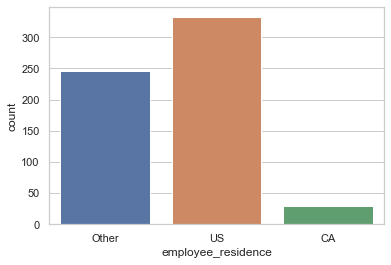

In [8]:
"""plots of counts for employee residence"""
data['employee_residence'] = data.employee_residence.apply(lambda x: 'Other' if x not in ('US', 'CA') else x)
sns.set_theme(style="whitegrid")
sns.countplot(x='employee_residence',data=data)

## Ordinal Encoding 

In [9]:
from sklearn.preprocessing import OrdinalEncoder

enc_exp_level = OrdinalEncoder(categories=[['EN', 'MI', 'SE', 'EX'],['S','M','L']]) # Ordinal variables are work exp and company size
data[['experience_level', 'company_size']] = enc_exp_level.fit_transform(data[['experience_level','company_size']])
print(enc_exp_level.categories_)

"""
Simple check to see if the above fit_transform method works as intended
data.experience_level.unique()
data.company_size.unique()
"""

[array(['EN', 'MI', 'SE', 'EX'], dtype=object), array(['S', 'M', 'L'], dtype=object)]


'\nSimple check to see if the above fit_transform method works as intended\ndata.experience_level.unique()\ndata.company_size.unique()\n'

## Nominal Encoding

Here I encode the nominal variables. 

### Additional notes on job titles

Some additional preprocessing is required: there are different job titles that should be categorized together (e.g. product data analyst and data analyst), since their salary expectations will be similar. Failing to do so would result in a significant amount of sparse columns (which do not meaningfully represent a difference) after creating dummy variables. Job titles are grouped by the last term in the title (e.g. 'ML Engineer' becomes 'Engineer'). Additionally, job titles that seem to reflect leadership roles (e.g. 'Lead' or 'Director') are grouped together as 'Senior' to more accurately reflect their responsibility and payscale similarity. Remaining roles that have a very low headcount are grouped together as 'Other'. This isn't particularly scientific but it sure is convenient.

In [10]:
data.job_title = data.job_title.apply(lambda x: 'Senior' if ('Lead' in x or 'Principal' in x or 'Head' in x or 'Director' in x or 'Manager' in x) else x)
data.job_title = data.job_title.map(lambda x: x.split(' ')[-1])
data.job_title = data.job_title.map(lambda x: 'Other' if ('Architect' in x or 'Consultant' in x or 'Developer' in x or 'Researcher' in x or 'Specialist' in x) else x)
print(data.job_title.value_counts())



Engineer     213
Scientist    184
Analyst      114
Senior        70
Other         26
Name: job_title, dtype: int64


In [11]:
"""
Encoding nominal variables. Note here that I append 'work_year', 'remote_ratio', and 'company_location', as those are not continuous 
variables either.
"""

nominal_col = data.columns[data.columns.map(lambda x: x not in ['experience_level', 'company_size'] and data[x].dtype == 'object')].values
nominal_col = np.append(nominal_col, ['work_year','remote_ratio', 'company_location'])
print(nominal_col)
"""
test = pd.get_dummies(data=data, columns=nominal_col, drop_first=True)
print(test.head())
"""


['employment_type' 'job_title' 'employee_residence' 'work_year'
 'remote_ratio' 'company_location']


'\ntest = pd.get_dummies(data=data, columns=nominal_col, drop_first=True)\nprint(test.head())\n'

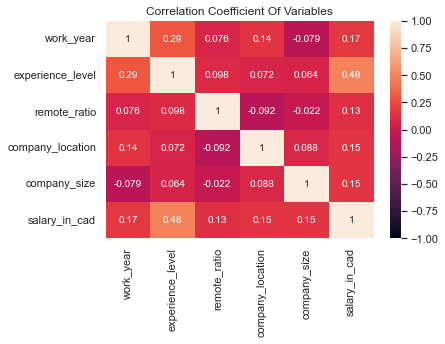

In [12]:
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Variables')
plt.show()

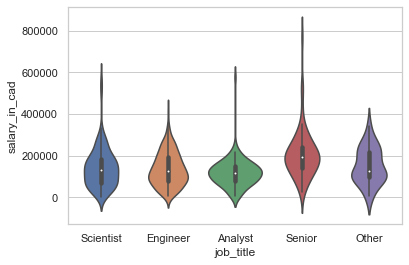

In [14]:
ax = sns.violinplot(x="job_title", y="salary_in_cad", data=data)

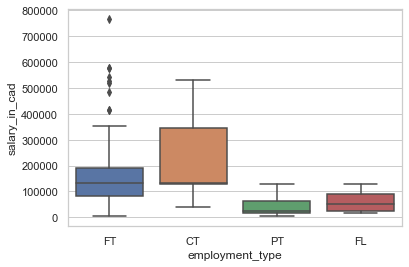

In [16]:
ax = sns.boxplot(x="employment_type", y="salary_in_cad", data=data)

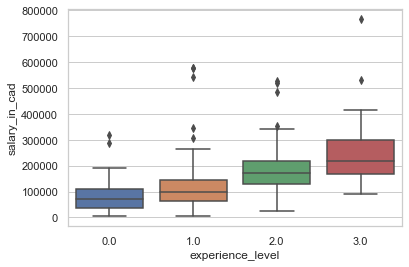

In [17]:
ax = sns.boxplot(x="experience_level", y="salary_in_cad", data=data)

In [19]:
test = pd.get_dummies(data=data, columns=nominal_col, drop_first=True)
print(test.shape)
print(test)

(607, 17)
     experience_level  company_size  salary_in_cad  employment_type_FL  \
0                 1.0           2.0      102186.24                   0   
1                 2.0           0.0      332800.00                   0   
2                 2.0           1.0      139550.72                   0   
3                 1.0           0.0       25600.00                   0   
4                 2.0           2.0      192000.00                   0   
..                ...           ...            ...                 ...   
602               2.0           1.0      197120.00                   0   
603               2.0           1.0      161280.00                   0   
604               2.0           1.0      165120.00                   0   
605               2.0           1.0      192000.00                   0   
606               1.0           2.0      256000.00                   0   

     employment_type_FT  employment_type_PT  job_title_Engineer  \
0                     1           

# Preliminary EDA 

Nothing serious here. 

For OLS to work the outcome variable (salary_in_cad) is assumed to be normal. Well, let us verify with a plot. As an added bonus, we would also get to see potential outliers.

<AxesSubplot:xlabel='salary_in_cad', ylabel='Count'>

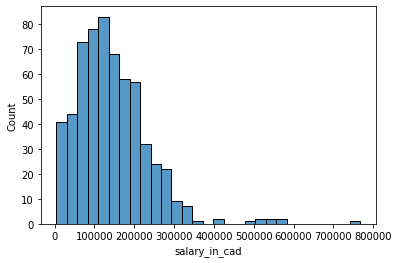

In [56]:
sns.histplot(test['salary_in_cad'])

Yikes, that's not good. Taking the log scale (log 10 seems apropos as we commonly think of salaries in factors of 10 e.g. 5 figures/6 figures dichotomies)

<AxesSubplot:xlabel='salary_in_cad', ylabel='Count'>

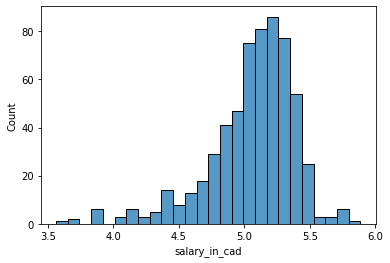

In [57]:
test['salary_in_cad'] = np.log10(test['salary_in_cad'])
sns.histplot(test['salary_in_cad'])


While the distribution looks improved, there is still a noticeable left skew. Removal of non full-time roles and values < 4.4 (about the minimum annual salary in Canada)

We could also consider keeping all of the data points and apply a more severe transformation, such as a BoxCox power transform or some kind of transform variant from the scikit-learn package. However, it would cost us the ability to easily interpret the coefficients for OLS. 

(607, 119)
(564, 119)


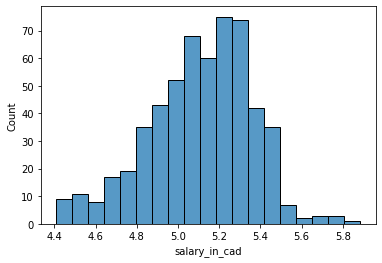

In [62]:
test2 = test[(test['employment_type_FT']==1) & (test['salary_in_cad'] >= 4.4)]
sns.histplot(test2['salary_in_cad'])
print(test.shape)
print(test2.shape)

Approximately resembles a normal distribution at a cost of ~8% of our data points. Good enough. Std error estimates might be under-estimated

# Model 1. OLS (Ol' Reliable)

Before we get into splitting the data set into testing and training, outliers etc. let's examine the diagnostic plots.

It's pretty bad.

In [64]:
import statsmodels.api as sm 
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn')

y = test['salary_in_cad']
X = test.drop(columns='salary_in_cad')

# generate OLS model
model = sm.OLS(y, sm.add_constant(X))
model_fit = model.fit()

# create dataframe from X, y for easier plot handling
diagnostic_plot_df = pd.concat([X, y], axis=1)


/Users/danielyang/Library/Caches/pypoetry/virtualenvs/smart-technologies-interview-presentation-FMutRnCN-py3.10/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:696: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/Users/danielyang/Library/Caches/pypoetry/virtualenvs/smart-technologies-interview-presentation-FMutRnCN-py3.10/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:696: RuntimeWarning: divide by zero encountered in divide
  return self.resid / sigma / np.sqrt(1 - hii)
/Users/danielyang/Library/Caches/pypoetry/virtualenvs/smart-technologies-interview-presentation-FMutRnCN-py3.10/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:716: RuntimeWarning: divide by zero encountered in divide
  cooks_d2 *= hii / (1 - hii)
/Users/danielyang/Library/Caches/pypoetry/virtualenvs/smart-technologies-interview-presentation-FMutRnCN-py3.10/lib/python3.10/site-packages/seaborn/_decorators.p

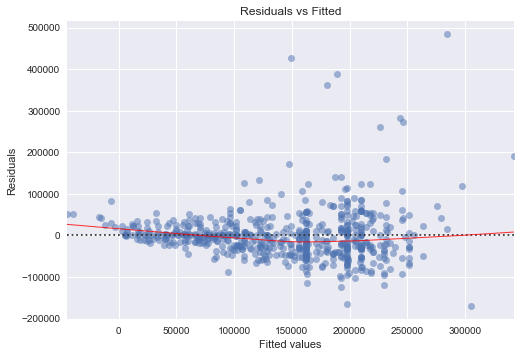

In [66]:
# model values
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, diagnostic_plot_df.columns[-1], data=diagnostic_plot_df,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');


/Users/danielyang/Library/Caches/pypoetry/virtualenvs/smart-technologies-interview-presentation-FMutRnCN-py3.10/lib/python3.10/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


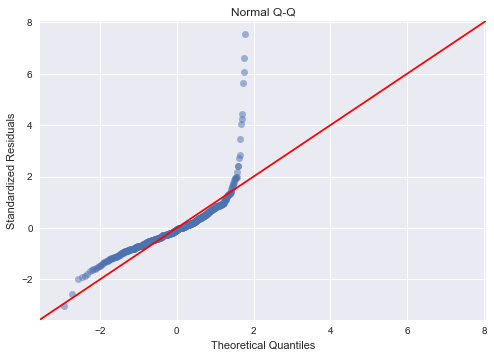

In [67]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

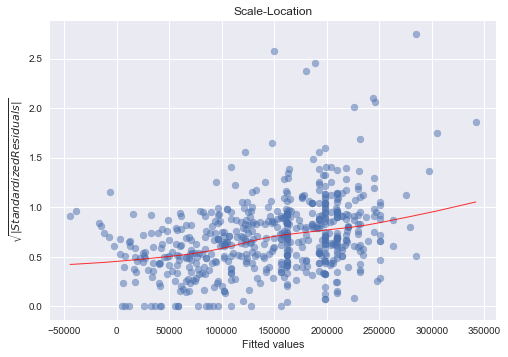

In [69]:
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i,
                                xy=(model_fitted_y[i],
                                    model_norm_residuals_abs_sqrt[i]));


Fitting in the log_10 scale instead:

/Users/danielyang/Library/Caches/pypoetry/virtualenvs/smart-technologies-interview-presentation-FMutRnCN-py3.10/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:696: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/Users/danielyang/Library/Caches/pypoetry/virtualenvs/smart-technologies-interview-presentation-FMutRnCN-py3.10/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:696: RuntimeWarning: divide by zero encountered in divide
  return self.resid / sigma / np.sqrt(1 - hii)
/Users/danielyang/Library/Caches/pypoetry/virtualenvs/smart-technologies-interview-presentation-FMutRnCN-py3.10/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:716: RuntimeWarning: divide by zero encountered in divide
  cooks_d2 *= hii / (1 - hii)
/Users/danielyang/Library/Caches/pypoetry/virtualenvs/smart-technologies-interview-presentation-FMutRnCN-py3.10/lib/python3.10/site-packages/seaborn/_decorators.p

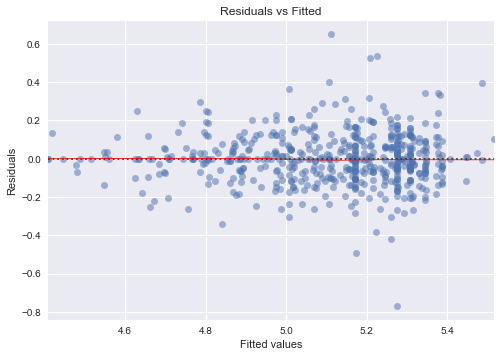

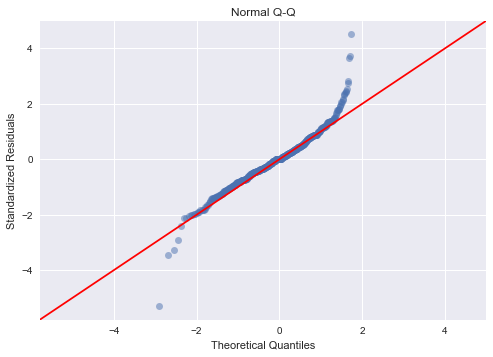

In [71]:
y = test2['salary_in_cad']
X = test2.drop(columns='salary_in_cad')

# generate OLS model
model = sm.OLS(y, sm.add_constant(X))
model_fit = model.fit()

# create dataframe from X, y for easier plot handling
diagnostic_plot_df = pd.concat([X, y], axis=1)

model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, diagnostic_plot_df.columns[-1], data=diagnostic_plot_df,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));



Seems good enough. QQ plot could be better, but nothing so egregious that it breaks the analysis. OK! Running the model now.

In [21]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from statsmodels.graphics.gofplots import ProbPlot
test2 = test[(test['employment_type_FT']==1) & (test['salary_in_cad'] >= 4.4)]
test2 = test2.drop(columns=['employment_type_PT', 'employment_type_FL', 'employment_type_FT'])
y = np.log10(test2['salary_in_cad'])
X = test2.drop(columns='salary_in_cad')

# generate OLS model
model = sm.OLS(y, sm.add_constant(X))
model_fit = model.fit()
print(model_fit.summary())


                            OLS Regression Results                            
Dep. Variable:          salary_in_cad   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     52.15
Date:                Thu, 11 Aug 2022   Prob (F-statistic):           2.66e-88
Time:                        22:10:03   Log-Likelihood:                 60.058
No. Observations:                 588   AIC:                            -92.12
Df Residuals:                     574   BIC:                            -30.84
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [11]:
from statsmodels.tools.eval_measures import rmse

# fit your model which you have already done

# now generate predictions
ypred = model_fit.predict(sm.add_constant(X))
print(y)
# calc rmse
rmse = rmse(y, ypred)
print(rmse)

# RMSE for unaltered employee residence: 0.1646
# RMSE for altered employee residence: 0.21847607996420185

0      5.009392
1      5.522183
2      5.144732
3      4.408240
4      5.283301
         ...   
602    5.294731
603    5.207581
604    5.217800
605    5.283301
606    5.408240
Name: salary_in_cad, Length: 588, dtype: float64
0.21847607996420185


In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
vif_test = add_constant(test2)
pd.Series([variance_inflation_factor(vif_test.values, i) 
               for i in range(vif_test.shape[1])], 
              index=vif_test.columns)
              

const                       64.071517
experience_level             1.534514
company_size                 1.116830
salary_in_cad                1.935222
job_title_Engineer           2.004107
job_title_Other              1.228301
job_title_Scientist          1.990803
job_title_Senior             1.811675
employee_residence_Other     6.366679
employee_residence_US        6.129789
work_year_2021               2.686036
work_year_2022               3.119378
remote_ratio_50              1.701403
remote_ratio_100             1.536627
company_location_1           1.195946
dtype: float64

# Models (OLS/LASSO-Ridge-ElasticNet/Trees)

Coefficients: 
 [ 0.1006055   0.02591353  0.08565976  0.15138781  0.12089866  0.21080728
 -0.21063995  0.16287079 -0.06346716  0.01515872  0.07330751  0.01585528
 -0.10422234]
Mean squared error: 0.08
Mean absolute error: 0.18
Coefficient of determination: 0.49


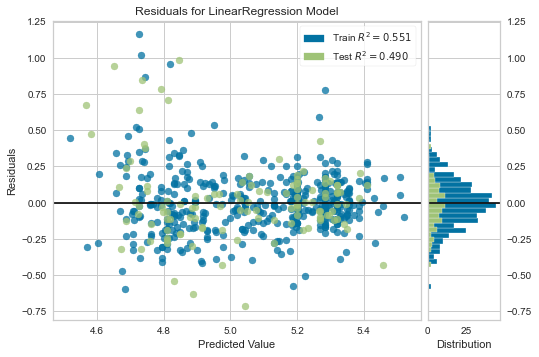

'\ny_residuals = y_pred - y_test \nplt.scatter(y_pred,y_residuals)\nplt.show()'

In [29]:
"""OLS with Test/Train"""
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from yellowbrick.regressor import ResidualsPlot

test2['salary_in_cad'] = np.log10(test['salary_in_cad'])
y = test2['salary_in_cad']
X = test2.drop(columns=['salary_in_cad'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)
lin_reg = LinearRegression().fit(X_train, y_train)
lin_reg.score(X_train, y_train)
y_pred = lin_reg.predict(X_test)

#print(X_train)
# The coefficients
print("Coefficients: \n", lin_reg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The mean abs. error
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

"""
y_residuals = y_pred - y_test 
plt.scatter(y_pred,y_residuals)
plt.show()"""

In [33]:
X.experience_level.unique()

array([1., 2., 0., 3.])

In [34]:
print(X_test.head())
me = np.array([0.0, 1.0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1])
me_pred = lin_reg.predict(me.reshape(1,-1))
print(me_pred) # returns 4.93 

"""10**4.93 = 86896.04"""

     experience_level  company_size  job_title_Engineer  job_title_Other  \
544               2.0           1.0                   1                0   
498               2.0           2.0                   0                0   
406               1.0           0.0                   0                0   
174               2.0           2.0                   0                0   
522               1.0           0.0                   0                0   

     job_title_Scientist  job_title_Senior  employee_residence_Other  \
544                    0                 0                         0   
498                    1                 0                         1   
406                    0                 0                         0   
174                    1                 0                         1   
522                    0                 0                         1   

     employee_residence_US  work_year_2021  work_year_2022  remote_ratio_50  \
544                      1     

/Users/danielyang/Library/Caches/pypoetry/virtualenvs/smart-technologies-interview-presentation-FMutRnCN-py3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


"While I'm not complaining, 10**5.04 = 109647 does seem to fall on the high side!"

In [30]:
from sklearn.linear_model import RidgeCV
from yellowbrick.regressor import AlphaSelection

alphas = np.logspace(-10, 1, 200)
ridge_model = RidgeCV(alphas=alphas).fit(X_train, y_train)

ridge_model.score(X_train, y_train)
y_pred = ridge_model.predict(X_test)
# The coefficients
print("Coefficients: \n", ridge_model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

print(ridge_model.get_params)

Coefficients: 
 [ 0.10316526  0.02647678  0.06520964  0.11571442  0.1008805   0.18075546
 -0.19637758  0.16475652 -0.05860142  0.01432729  0.06513277  0.01567225
 -0.08740867]
Mean squared error: 0.08
Mean absolute error: 0.18
Coefficient of determination: 0.48
<bound method BaseEstimator.get_params of RidgeCV(alphas=array([1.00000000e-10, 1.13573336e-10, 1.28989026e-10, 1.46497140e-10,
       1.66381689e-10, 1.88965234e-10, 2.14614120e-10, 2.43744415e-10,
       2.76828663e-10, 3.14403547e-10, 3.57078596e-10, 4.05546074e-10,
       4.60592204e-10, 5.23109931e-10, 5.94113398e-10, 6.74754405e-10,
       7.66341087e-10, 8.70359136e-10, 9.88495905e-10, 1.12266777e-09,
       1.27505124e-09, 1.44811823e-0...
       5.35356668e-01, 6.08022426e-01, 6.90551352e-01, 7.84282206e-01,
       8.90735464e-01, 1.01163798e+00, 1.14895100e+00, 1.30490198e+00,
       1.48202071e+00, 1.68318035e+00, 1.91164408e+00, 2.17111795e+00,
       2.46581108e+00, 2.80050389e+00, 3.18062569e+00, 3.61234270e+00,
  

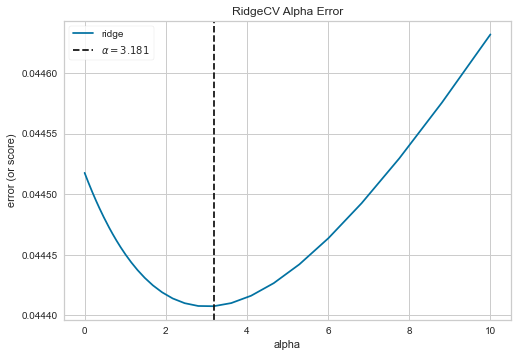

<AxesSubplot:title={'center':'RidgeCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [35]:
visualizer = AlphaSelection(RidgeCV(alphas=alphas))
visualizer.fit(X_train, y_train)
visualizer.show()

In [31]:
from sklearn.linear_model import LassoCV

lasso_model = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
lasso_model.score(X_train, y_train)

y_pred = lasso_model.predict(X_test)

print("Coefficients: \n", lasso_model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficients: 
 [ 0.10123195  0.02547605  0.07955229  0.14069463  0.11487499  0.20284268
 -0.20885282  0.16205205 -0.06243353  0.01320076  0.06849525  0.01389167
 -0.09879248]
Mean squared error: 0.08
Mean absolute error: 0.18
Coefficient of determination: 0.49


In [32]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)

   experience_level  company_size  job_title_Engineer  job_title_Other  \
0               1.0           2.0                   0                0   
1               2.0           0.0                   0                0   
2               2.0           1.0                   1                0   
3               1.0           0.0                   0                0   
4               2.0           2.0                   1                0   

   job_title_Scientist  job_title_Senior  employee_residence_Other  \
0                    1                 0                         1   
1                    1                 0                         1   
2                    0                 0                         1   
3                    0                 0                         1   
4                    0                 0                         0   

   employee_residence_US  work_year_2021  work_year_2022  remote_ratio_50  \
0                      0               0               0 

# Final Notes + Summary

Was decided to only look at Full Time positions, necessarily removing the employment type columns. 